In [1]:
import time, json, math
from tqdm.autonotebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from py2neo import Graph, Node, Relationship
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [318]:
graph = Graph('bolt://neo4j-allquanta:7687', auth=('neo4j','myneo'))

n_nodes = graph.database.primitive_counts['NumberOfNodeIdsInUse']
n_relationships = graph.database.primitive_counts['NumberOfRelationshipIdsInUse']
print("Connected to graph database with {:,} nodes and {:,} relationships!".format
     (n_nodes, n_relationships))

Connected to graph database with 278,432,359 nodes and 1,844,501,832 relationships!


In [2]:
start_year, end_year, step = 2000, 2018, 1
min_year_year = 1950

def run_query(query, graph, print_query=False, run_query=True, 
              print_only=False, to_df=False):
    df = 1
    if print_only: 
        print_query = True
        run_query = False
    start_time = time.time()
    if print_query:
        print(query)
    if run_query:
        if to_df:
            df = graph.run(query).to_data_frame()
        else:
            graph.run(query)
    end_time = time.time()
    minutes_elapsed = (end_time-start_time)/60
    print("Query completed in {:.2f} minutes.".format(minutes_elapsed))
    return df

In [3]:
## Collect data for given area of interest
# time-scaled PageRank by all Nature authors from start_year to end_year

tspr_sums = ',\n    '.join(['SUM(q.tsprn{}) as tsprn{}'.format(i,i) for i in range(start_year, end_year+1)])

query = """
MATCH (a:NatureAuthor)-[:AUTHORED]->(p:Quanta)
WHERE (p.year > {} AND p.year < {}) AND (p.venue="Nature") 

AND ("Malaria" in p.fos OR "MALARIA" in p.fos OR "malaria" in p.fos OR
     "malaria" in p.keywords OR "MALARIA" in p.keywords)
     
WITH *, collect(a) as alist
MATCH (b)-[:AUTHORED]->(q:Quanta {{venue:"Nature"}})
WHERE b IN alist
RETURN 
    a.name as name, 
    {}
""".format(start_year-1, end_year+1, tspr_sums)
df = run_query(query, graph, to_df=True, print_only=True)
old_df = df
print("Found {:,} authors.".format(len(df.index)))

# AND ("CRISPR" in p.fos OR "Cas9" in p.fos OR "Crispr" in p.fos OR
#      "crispr" in p.keywords OR "cas9" in p.keywords)

NameError: name 'graph' is not defined

In [461]:
## Clean and format data

# Convert to time series matrix
df = old_df.T
df.columns = df.loc['name'].tolist()
df = df.drop(index='name')

# Drop columns with zeros
# names_to_drop = df.columns[(df==0).any()]
# df = df.drop(columns=names_to_drop)
df = df.clip(lower=1e-4)
n_authors = df.shape[1]
print("Now have {:,} authors.".format(n_authors))

# Convert rows to Datetime
df.index = pd.to_datetime(['01/01/{}'.format(s[-4:]) for s in df.index],
               infer_datetime_format=True)

# Convert all data to float type
df = df.astype(float)

# Calculate log returns
log_ret = np.log(df/df.shift(1))
log_ret = log_ret.iloc[1:,]

df.head()

Now have 69 authors.


,Luciano A. Marraffini,Joe Bondy-Denomy,Guillermo Montoya,Alexandra East-Seletsky,Spencer C. Knight,Samuel H. Sternberg,Wenyan Jiang,Thomas A. Kunkel,Martin Jinek,Krzysztof Chylinski,...,Yongjoo Kim,Maria R. Eckert,Sylvain Moineau,Alan Engelman,Robert Tjian,Rodolphe Barrangou,Josiane E. Garneau,Philippe Horvath,Karen L. Maxwell,Manuela Villion
2000-01-01,0.0001,0.0001,0.291415,0.0001,0.0001,0.0001,0.0001,1.217327,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,16.177005,0.0001,0.0001,0.0001,0.0001,0.0001
2001-01-01,0.0001,0.0001,0.298615,0.0001,0.0001,0.0001,0.0001,1.295426,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,17.048163,0.0001,0.0001,0.0001,0.0001,0.0001
2002-01-01,0.0001,0.0001,0.308327,0.0001,0.0001,0.0001,0.0001,1.325646,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,18.563970,0.0001,0.0001,0.0001,0.0001,0.0001
2003-01-01,0.0001,0.0001,0.302979,0.0001,0.0001,0.0001,0.0001,1.356467,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,17.748922,0.0001,0.0001,0.0001,0.0001,0.0001
2004-01-01,0.0001,0.0001,0.195469,0.0001,0.0001,0.0001,0.0001,1.372401,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,17.126196,0.0001,0.0001,0.0001,0.0001,0.0001


In [462]:
## Monte Carlo Simulation 

n_grants = 200000
n_authors_per_grant = 4

np.random.seed(42)
all_weights = np.zeros((n_grants, n_authors_per_grant))
all_authors = []
ret_arr = np.zeros(n_grants)
vol_arr = np.zeros(n_grants)
sharpe_arr = np.zeros(n_grants)

for x in tqdm(range(n_grants)):
    
    # Select assets (authors)
    authors = random.sample(list(df.columns), k=n_authors_per_grant)
    all_authors.append(authors)
    returns = log_ret.loc[:,authors]
    
    # Random weights
    weights = np.array(np.random.random(n_authors_per_grant))
    weights = weights/np.sum(weights)
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (returns.mean() * weights))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]


max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]
print("Maximum Sharpe ratio: {}".format(sharpe_arr.max()))
print("\tLocation in array: {}".format(sharpe_arr.argmax()))
print("\tImpact: {}".format(max_sr_ret))
print("\tRisk: {}".format(max_sr_vol))
print("\tResearchers: \n\t\t{}".format(',\n\t\t'.join(all_authors[sharpe_arr.argmax()])))
print("\tWeighting: {}".format(all_weights[sharpe_arr.argmax()]))

Maximum Sharpe ratio: 0.8170207470051981
	Location in array: 86202
	Impact: 0.10513594641975291
	Risk: 0.1286821011646648
	Researchers: 
		David Burstein,
		George M. Church,
		Michael A. Resnick,
		Jennifer A. Doudna
	Weighting: [ 0.3480099   0.16087009  0.0926304   0.3984896 ]


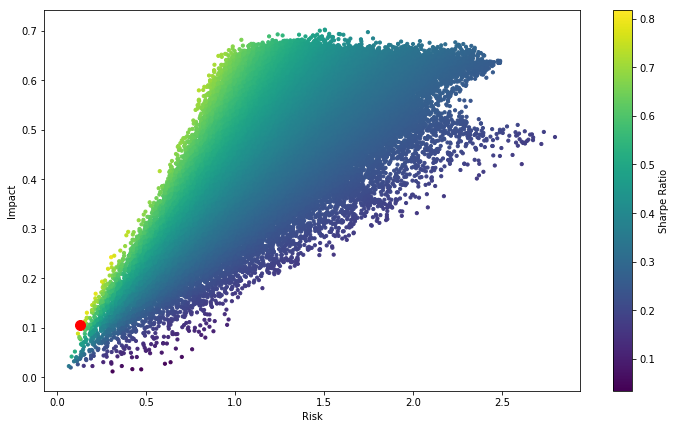

In [463]:
## Plot results
plt.figure(figsize=(12,7))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, s=10, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Risk')
plt.ylabel('Impact')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=100) # red dot
plt.axis('tight')
plt.show()

In [414]:
## Solve for best grant
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]



In [415]:
from scipy.optimize import minimize

cons = ({'type':'eq', 'fun':check_sum})
bounds = ((0,1),)*log_ret.shape[1]
init_guess = [1/log_ret.shape[1]]*log_ret.shape[1]

opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [416]:


old_df['name'][opt_results.x>1e-3]

2       Guillermo Montoya
5     Samuel H. Sternberg
8            Martin Jinek
21       Alan R. Davidson
36     Erik J. Sontheimer
37         David Burstein
38     Michael A. Resnick
39     Jennifer A. Doudna
61        Sylvain Moineau
68        Manuela Villion
Name: name, dtype: object

In [359]:
get_ret_vol_sr(opt_results.x)
frontier_y = np.linspace(0,ret_arr.max()+1,10)

frontier_x = []

for possible_return in tqdm(frontier_y):
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:16<02:27, 16.43s/it]

 20%|██        | 2/10 [00:27<01:57, 14.74s/it]

 30%|███       | 3/10 [00:43<01:47, 15.29s/it]

 40%|████      | 4/10 [01:00<01:33, 15.62s/it]

 50%|█████     | 5/10 [01:16<01:19, 15.90s/it]

 60%|██████    | 6/10 [01:17<00:45, 11.31s/it]

 70%|███████   | 7/10 [01:18<00:24,  8.14s/it]

 80%|████████  | 8/10 [01:19<00:12,  6.10s/it]

 90%|█████████ | 9/10 [01:20<00:04,  4.62s/it]

100%|██████████| 10/10 [01:21<00:00,  3.59s/it]

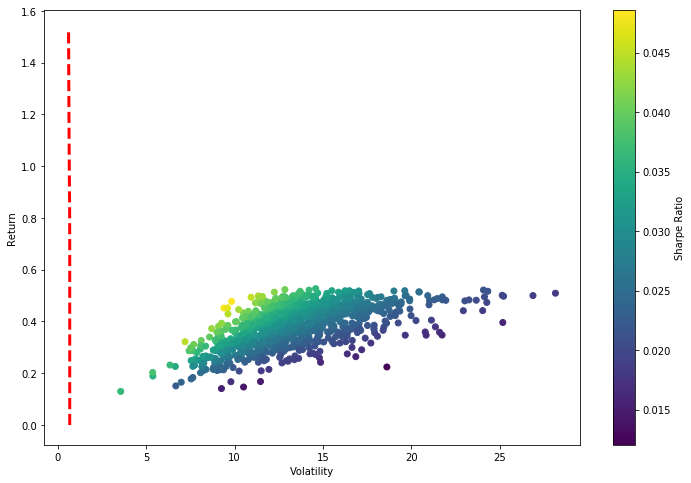

In [360]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.savefig('cover.png')
plt.show()